In [1]:
!pip install -q insightface==0.7.3 onnxruntime-gpu opencv-python faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 27.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os, time, collections
from pathlib import Path
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import faiss
from insightface.app import FaceAnalysis

In [5]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
RAW_DIR   = '/content/gdrive/MyDrive/Image/raw_images'      # originals (1–3 images per folder)
ALIGN_DIR = '/content/gdrive/MyDrive/Image/face3_align'     # aligned & augmented output
IMG_SZ    = 112
SEQ_N     = 3
Path(ALIGN_DIR).mkdir(parents=True, exist_ok=True)

# 2) FaceAnalysis initialisation (detection + embedding)

det = FaceAnalysis(
    allowed_modules=["detection", "recognition"],
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
)
det.prepare(ctx_id=0, det_thresh=0.6)

rec_model = det.models["recognition"]   # ArcFace 512‑D embedding model



# 3) Detection → manual bbox crop → resize (112×112) → save
print("===== STEP 3: Detection → Alignment (bbox crop) =====")
for cls in sorted(Path(RAW_DIR).iterdir()):
    if not cls.is_dir():
        continue
    out_cls = Path(ALIGN_DIR) / cls.name
    out_cls.mkdir(parents=True, exist_ok=True)

    for p in sorted(cls.glob("*")):
        img = cv2.imread(str(p))
        if img is None:
            print(f"[ERROR] {cls.name}/{p.name}: failed to load image")
            continue

        faces = det.get(img)
        if len(faces) == 0:
            print(f"[WARNING] {cls.name}/{p.name}: no face detected")
            continue

        for i, face in enumerate(faces):
            x1, y1, x2, y2 = map(int, face["bbox"])
            cropped = img[y1:y2, x1:x2]
            if cropped.size == 0:
                print(f"[WARNING] {cls.name}/{p.name}: crop area is zero ({x1},{y1},{x2},{y2})")
                continue
            crop_resized = cv2.resize(cropped, (IMG_SZ, IMG_SZ))
            out_path = out_cls / f"{p.stem}_{i}.jpg"
            cv2.imwrite(str(out_path), crop_resized)
            print(f"    Saved aligned face: {out_path}")

print("Alignment (bbox crop) completed\n")

# 4) Quick check of ALIGN_DIR
print("===== STEP 4: Image count in ALIGN_DIR =====")
for cls in sorted(Path(ALIGN_DIR).iterdir()):
    if cls.is_dir():
        imgs = list(cls.glob("*.jpg"))
        print(f"    {cls.name}: {len(imgs)} images")
print()

# 5) Augmentation pipeline & embedding helpers
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(0.4, 0.4, p=0.6),
    A.MotionBlur(blur_limit=7, p=0.3),
    A.Rotate(limit=15, p=0.3),
    A.ImageCompression(quality_range=(40, 80), compression_type="jpeg", p=0.3),
])

def embed_rgb(rgb: np.ndarray) -> np.ndarray:
    """Return L2‑normalised ArcFace 512‑D embedding from an RGB image."""
    v = rec_model.get_feat(rgb).astype(np.float32)
    v /= np.linalg.norm(v)
    return v  # shape (512,)

def augment_and_embed(img_bgr: np.ndarray) -> list[np.ndarray]:
    """Return embeddings for the original + 2 augmented copies (total 3)."""
    imgs = [img_bgr] + [aug(image=img_bgr)["image"] for _ in range(2)]
    return [embed_rgb(im[:, :, ::-1]) for im in imgs]   # BGR→RGB

# 6) Class‑wise mean embedding → Leave‑One‑Out → θ calculation
print("===== STEP 6: Mean embedding + LOO (1–3 images) → θ =====")

id_names, id_vecs = [], []
pos_scores, neg_scores = [], []

for cls in sorted(Path(ALIGN_DIR).iterdir()):
    if not cls.is_dir():
        continue

    image_paths = sorted(cls.glob("*.jpg"))
    if len(image_paths) == 0:
        print(f"[SKIP] '{cls.name}' has 0 images, skipping")
        continue

    originals = image_paths[:3]  # use at most 3 images
    all_embs = []

    # (1) original + augmented → collect embeddings
    for p in originals:
        img = cv2.imread(str(p))
        if img is None:
            print(f"[ERROR] '{cls.name}/{p.name}': failed to load aligned image")
            continue
        all_embs.extend(augment_and_embed(img))

    if len(all_embs) == 0:
        print(f"[WARNING] '{cls.name}' has zero valid embeddings, skipping")
        continue

    centroid = np.mean(all_embs, axis=0).astype(np.float32)  # (512,)
    id_names.append(cls.name)
    id_vecs.append(centroid)
    print(f"    '{cls.name}': mean embedding created (samples: {len(all_embs)})")

    # (2) Leave‑One‑Out positive scores
    if len(originals) >= 2:
        for k, p_k in enumerate(originals):
            img_k = cv2.imread(str(p_k))
            if img_k is None:
                print(f"[ERROR] '{cls.name}/{p_k.name}': LOO load failed")
                continue
            test_emb = embed_rgb(img_k[:, :, ::-1]).flatten()

            train_embs = [
                embed_rgb(cv2.imread(str(p_j))[:, :, ::-1]).flatten()
                for j, p_j in enumerate(originals) if j != k
            ]
            if len(train_embs) == 0:
                print(f"[WARNING] '{cls.name}' LOO: train_embs is empty")
                continue

            train_centroid = np.mean(train_embs, axis=0).flatten()
            pos_scores.append(float(np.dot(test_emb, train_centroid)))
    else:
        print(f"[INFO] '{cls.name}' has {len(originals)} image(s), skipping LOO")

# (3) Negative scores
if len(id_vecs) >= 2:
    stacked = np.vstack(id_vecs).astype(np.float32)
    faiss.normalize_L2(stacked)
    for i, v in enumerate(stacked):
        others = np.delete(stacked, i, axis=0)
        neg_scores.extend((v @ others.T).tolist())
    print(f"    Negative scores computed (classes: {len(id_vecs)})")
else:
    print(f"[INFO] Only {len(id_vecs)} class(es); negative score calculation skipped")

# (4) θ estimation (approx. EER)
if pos_scores and neg_scores:
    y_true   = np.array([1]*len(pos_scores) + [0]*len(neg_scores))
    y_scores = np.array(pos_scores + neg_scores)
    best_gap, THRESH = 1.0, 0.35
    for t in np.linspace(0.20, 0.50, 61):
        FAR = (y_scores[y_true==0] >  t).mean()
        FRR = (y_scores[y_true==1] <= t).mean()
        if abs(FAR - FRR) < best_gap:
            best_gap, THRESH = abs(FAR - FRR), t
    print(f"    Auto‑selected θ = {THRESH:.3f}  (EER≈{best_gap:.3f})")
else:
    print("[WARNING] pos_scores or neg_scores missing, using default θ = 0.35")
    THRESH = 0.35

# (5) Build FAISS index
if id_vecs:
    vec_stack = np.vstack(id_vecs).astype(np.float32)
    faiss.normalize_L2(vec_stack)
    index = faiss.IndexFlatIP(vec_stack.shape[1])
    index.add(vec_stack)
    print(f"    FAISS index built (IDs: {len(id_vecs)})")
else:
    raise RuntimeError("id_vecs is empty; cannot build FAISS index")

print("STEP 6 completed\n")

# 7) Single‑image recognition helper

def recognise_image(path: str, save_path: str | None = None):
    """Detect and recognise faces in a single image, then save or return the annotated image."""
    img = cv2.imread(path)
    assert img is not None, f"Cannot read {path}"

    faces = det.get(img)
    if len(faces) == 0:
        print(f"[WARNING] No faces found in '{Path(path).name}'")

    for f in faces:
        x1, y1, x2, y2 = map(int, f["bbox"])
        crop = img[y1:y2, x1:x2]
        if crop.size == 0:
            print(f"[WARNING] Crop area is zero in '{Path(path).name}'")
            continue
        crop = cv2.resize(crop, (IMG_SZ, IMG_SZ))

        emb = embed_rgb(crop[:, :, ::-1]).reshape(1, -1)
        faiss.normalize_L2(emb)

        sc, idx = index.search(emb, 1)
        name = id_names[int(idx[0][0])] if sc[0][0] > THRESH else "Unknown"
        color = (0, 255, 0) if name != "Unknown" else (0, 0, 255)

        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            img,
            f"{name}:{sc[0][0]:.2f}",
            (x1, y1 - 8),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2,
        )

    if save_path:
        cv2.imwrite(save_path, img)
        print(f"Result saved to {save_path}")

    return img


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvid

In [8]:
def predict_image(path: str):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)

    faces = det.get(img)
    if len(faces) == 0:
        print("No face detected.")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("NoFace")
        plt.axis('off')
        plt.show()
        return 'NoFace', 0.0

    x1, y1, x2, y2 = map(int, faces[0]['bbox'])
    crop = cv2.resize(img[y1:y2, x1:x2], (IMG_SZ, IMG_SZ))

    emb = embed_rgb(crop[:, :, ::-1]).reshape(1, -1)
    faiss.normalize_L2(emb)

    sc, idx = index.search(emb, 1)
    name = id_names[int(idx[0][0])] if sc[0][0] > THRESH else 'Unknown'
    score = float(sc[0][0])

    annotated = img.copy()
    cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(annotated, f"{name}: {score:.2f}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title(f"{name} ({score:.2f})")
    plt.axis('off')
    plt.show()

    return name, score



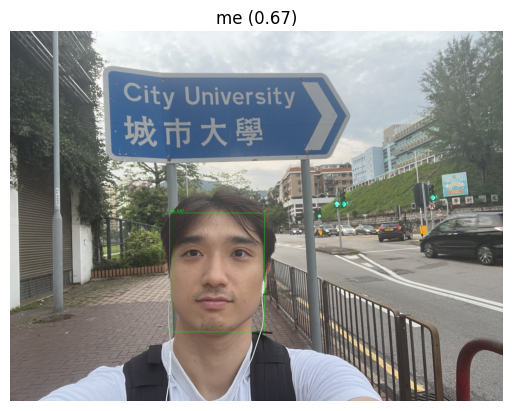

Prediction result → me  (Similarity 0.669)


In [10]:
import matplotlib.pyplot as plt

name, score = predict_image('/content/gdrive/MyDrive/Image/test/test3.jpg')
print(f"Prediction result → {name}  (Similarity {score:.3f})")